<a href="https://colab.research.google.com/github/DavideGioiosa/master-thesis-polimi/blob/master/RVAE_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Variational Autoencoder (RVAE) - Modified Notebook

This notebook is part of the official RVAE repository by Davide Gioiosa. 

## Modifications for Fair Comparison with SCL

For the purposes of fair and coherent testing and comparison with Symbolic Chord Loss (SCL), we have made specific modifications to the original codebase. These changes ensure that:

1. **Consistent Data Handling**: Both models process chord sequences in identical formats and representations
2. **Equivalent Evaluation Metrics**: Evaluation procedures are standardized across architectures
3. **Fair Complexity Assessment**: Harmonic complexity bins are computed using the same methodology
4. **Unified Generation Pipeline**: Generation from latent space follows comparable protocols

All modifications maintain the core architecture and functionality of RVAE while enabling rigorous comparative analysis between the two approaches.

---

# Regression Variational Autoencoder

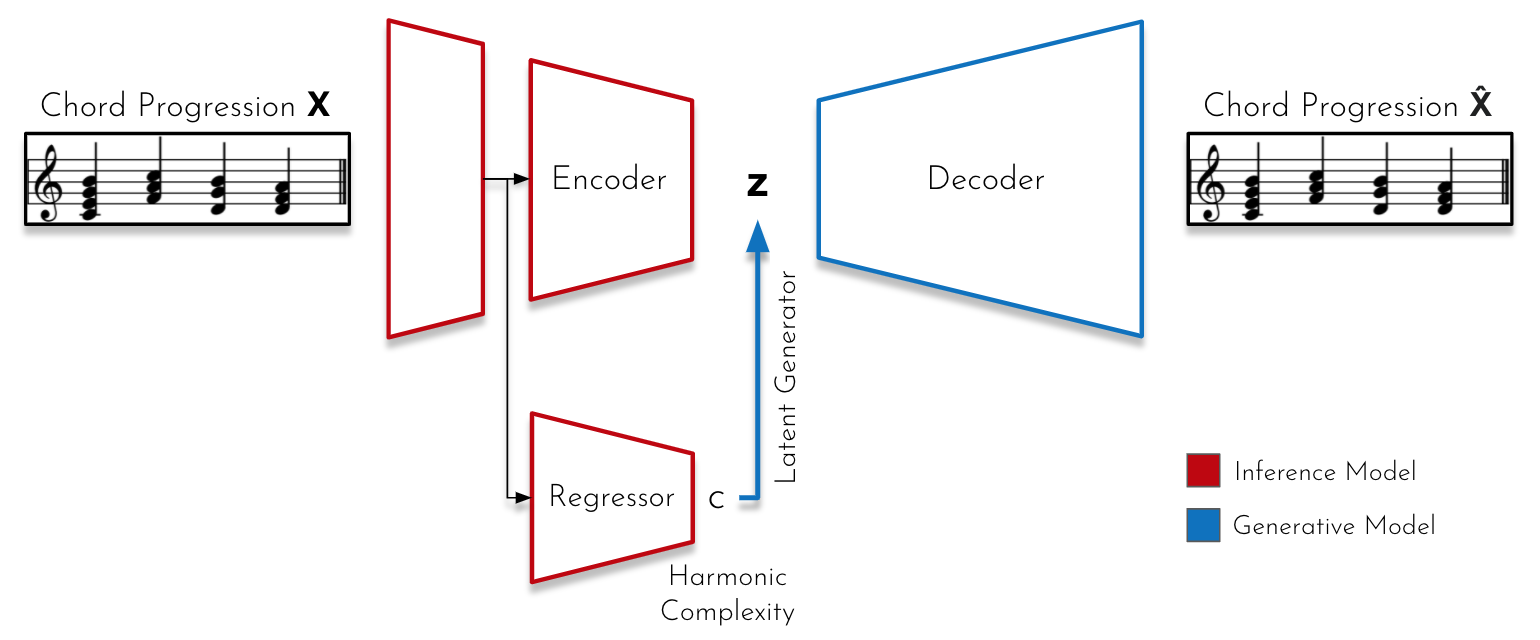

The architecture of the RVAE: the inference model (red) is composed by a probabilistic encoder and a probabilistic regressor, while the generative model by the latent generator and the decoder (blue). It is assumed that each chord sequence $\mathbf{X}$ is generate by its latent representation $\mathbf{z}$, which is dependent on the harmonic complexity ${c}$.

In [ ]:
import os
os.chdir('master-thesis-polimi')
os.getcwd()

In [ ]:
! pip install numpy
! pip install pandas
! pip install tensorflow
! pip install scipy
! pip install matplotlib
! pip install sklearn
! pip install scikit-learn
! pip install MIDIUtil
! pip install pretty_midi

**Note: Go to 'Runtime' -> 'Restart Runtime'**

The runtime must be restarted for google colab to use the version indicated in the requirements.txt for TensorFlow.

Then start running the code from here.

In [ ]:
import os

os.getcwd()

import pandas as pd
import numpy as np
from utils import constants, dataframe_utils
import random
from itertools import product
import pretty_midi
from Models.RVAE import RegressionVAE
from Generators.generator_rvae import GeneratorRVAE
from Generators.generator_rvae import LatentSpaceManagerRVAE
from utils.symbolic_format_converter import get_chord_sequence_symbolic_from_piano_roll

from utils.midi_synthesis import symbolic_2_midi
from utils import wav_synthesis

from collections import defaultdict
from utils.clean_algorithm import get_cleaned_sequence
from utils import constants

/Users/pepebeats/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
"""
Load Dataset from csv: Chord Sequences in Piano Roll format / Multi-hot vector format
5 chords per sequence, 1 octave -> 5x12 matrix
"""
df = pd.read_csv('R_Pretrain.csv')
df_sequences = dataframe_utils.get_chord_sequences_from_csv(df)

print("N. of chord sequences per each of the " + str(constants.COMPLEXITY_BINS) + " complexity classes")
print(df.groupby('Bin').size())

"""
Dataset split
"""
train_size = 0.7
val_size = 0.1
test_size = 0.2
train_data_PR, valid_data_PR, test_data_PR = dataframe_utils.split_train_test_validation(df, val_size, test_size)

"""
Chord sequences in np.array format:
 all sequences (array) -> sequence (5 arrays) -> chord (array, 1x12)
"""
train_data_sequences = dataframe_utils.get_chord_sequences_from_csv(train_data_PR)
valid_data_sequences = dataframe_utils.get_chord_sequences_from_csv(valid_data_PR)
test_data_sequences = dataframe_utils.get_chord_sequences_from_csv(test_data_PR)

train_data_sequences_flat = train_data_sequences.reshape(len(train_data_sequences), -1)
valid_data_sequences_flat = valid_data_sequences.reshape(len(valid_data_sequences), -1)
test_data_sequences_flat = test_data_sequences.reshape(len(test_data_sequences), -1)

N. of chord sequences per each of the 30 complexity classes
Bin
0      68
1     127
2      82
3     120
4      25
5      67
6      19
7      57
8      96
9     140
10    163
11    182
12    144
13    138
14     39
15     45
dtype: int64


In [3]:
train_bins = np.array(train_data_PR['Bin']).reshape(-1, 1)
valid_bins = np.array(valid_data_PR['Bin']).reshape(-1, 1)

regression_vae = RegressionVAE(n_epochs=600)
regression_vae.train(
    train_data_sequences_flat, train_bins,
    valid_data_sequences_flat, valid_bins
)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_sequence (InputLayer  [(None, 60)]                 0         []                            
 )                                                                                                
                                                                                                  
 dense (Dense)               (None, 512)                  31232     ['input_sequence[0][0]']      
                                                                                                  
 dropout (Dropout)           (None, 512)                  0         ['dense[0][0]']               
                                                                                                  
 dense_1 (Dense)             (None, 256)                  131328    ['dropout[0][0]']       

34/34 [==============================] - 0s 652us/step


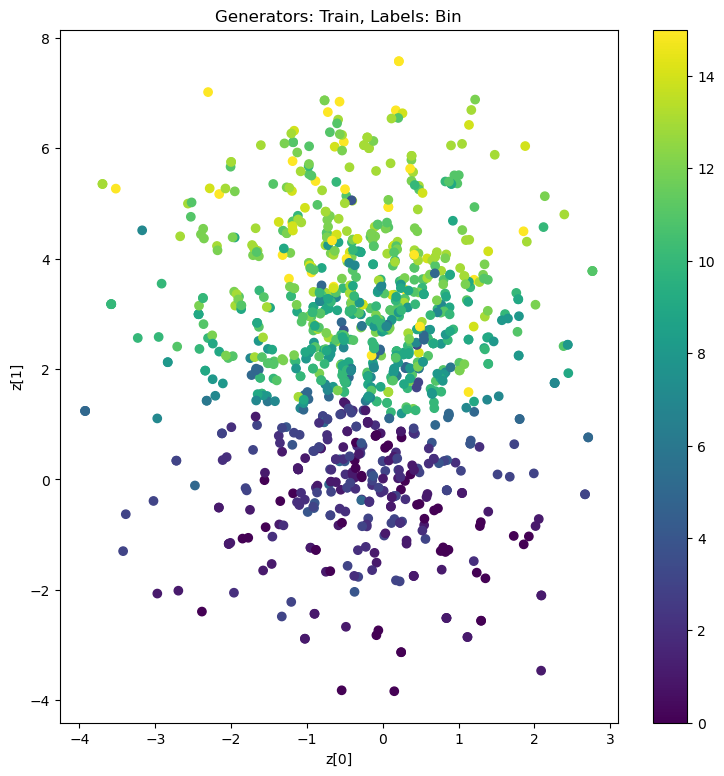

In [4]:
regression_vae.plots(train_data_sequences_flat, np.array(train_data_PR['Bin']), "Train")

## Examples of generation from latent space


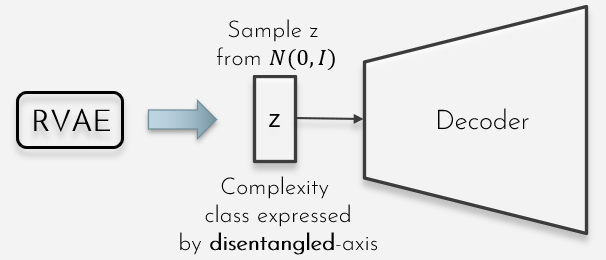

Generate sequence with a X complexity
- Coordinate on complexity axis: Move into the value range associated with the chosen complexity bin
- Move 'freely' on the other axis

**Set the boolean depending on the complexity axis (vertical or horizontal)**

In [5]:
is_vertical = True
latent_space_manager = LatentSpaceManagerRVAE(df, df_sequences, regression_vae.encoder, is_vertical)
generator_RVAE = GeneratorRVAE(latent_space_manager, regression_vae.decoder)


In [ ]:
print("Real Bins:", latent_space_manager.existing_bins)
print("N Real bins:", len(latent_space_manager.existing_bins))
print("COMPLEXITY_RANGE:", constants.COMPLEXITY_RANGE)

Bins reales: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Cantidad bins reales: 16
COMPLEXITY_RANGE: 6


In [ ]:
# 1st Method: indicating the reduced complexity bin [0–2]
print(get_chord_sequence_symbolic_from_piano_roll(
    generator_RVAE.generate_with_complexity_reduced(2)
))
print("\n")
print(get_chord_sequence_symbolic_from_piano_roll(
    generator_RVAE.generate_with_complexity_reduced(0)
))


Range on c-axis for the complexity bin (reduced)  2 :
[11.924222946166992, 12.650445938110352, 13.570135116577148, 14.57915210723877]
Z:  12.9279   2.4477
1/1 [==============================] - 0s 27ms/step
['Dmin', 'A#min', 'D#7', 'A7', 'A#maj']


Range on c-axis for the complexity bin (reduced)  0 :
[1.1539064645767212, 0.8036735653877258, 2.216280937194824, 3.156426191329956, 4.2791337966918945, 5.159493923187256]
Z:  1.2999   1.7261
1/1 [==============================] - 0s 9ms/step
['Gmaj', 'Cmaj', 'D7', 'Gmaj', 'Gmaj']


In [ ]:
print(get_chord_sequence_symbolic_from_piano_roll(generator_RVAE.generate_with_complexity_reduced_and_z_free(2,-0.8)))
print("\n")
print(get_chord_sequence_symbolic_from_piano_roll(generator_RVAE.generate_with_complexity_reduced_and_z_free(2,-0.1)))
print("\n")
print(get_chord_sequence_symbolic_from_piano_roll(generator_RVAE.generate_with_complexity_reduced_and_z_free(2,-1.3)))

Range on c-axis for the complexity bin (reduced)  2 :
[11.924222946166992, 12.650445938110352, 13.570135116577148, 14.57915210723877]
Z:  -0.8   13.1961
1/1 [==============================] - 0s 15ms/step
['Fmin', 'Emaj', 'Amaj', 'D#7', 'C#maj']


Range on c-axis for the complexity bin (reduced)  2 :
[11.924222946166992, 12.650445938110352, 13.570135116577148, 14.57915210723877]
Z:  -0.1   13.2619
1/1 [==============================] - 0s 10ms/step
['C#min', 'E7', 'Amaj', 'G#5', 'A#min']


Range on c-axis for the complexity bin (reduced)  2 :
[11.924222946166992, 12.650445938110352, 13.570135116577148, 14.57915210723877]
Z:  -1.3   13.0943
1/1 [==============================] - 0s 11ms/step
['Fmin', 'Emaj', 'Amaj', 'D#7', 'C#min']


In [ ]:
def enrich_from_input(
    x_flat,
    c_bin_input,
    c_bin_target,
    regression_vae,
    latent_space_manager,
    alpha=0.7,
    z_free_range=(-2.5, 2.5),
    verbose=True
):
    """
    Enrich a chord progression by moving its latent representation
    toward a target harmonic complexity bin.
    Assumes fixed-length progressions (N_MEASURES x N_PITCHES).
    """

    # -----------------------------
    # 1. Encode input progression
    # -----------------------------
    x_flat = np.asarray(x_flat, dtype=np.float32).reshape(1, -1)
    c_bin_input = np.asarray([[c_bin_input]], dtype=np.float32)

    z_mean, _, _, r_mean, _, _, _ = regression_vae.encoder.predict(
        [x_flat, c_bin_input], verbose=0
    )

    z_mean = z_mean[0]
    r_pred = float(r_mean[0, 0])

    if verbose:
        print("Input z:", z_mean)
        print("Predicted complexity:", r_pred)

    # -----------------------------
    # 2. Sample latent target from bin
    # -----------------------------
    c_range = latent_space_manager.get_range_of_complexity_bin_reduced(
        c_bin_target
    )

    if not c_range:
        raise ValueError(f"Invalid or empty target complexity bin: {c_bin_target}")

    z_complexity = random.uniform(c_range[0], c_range[-1])
    z_free = random.uniform(*z_free_range)

    if latent_space_manager.is_complexity_axis_vertical:
        z_target = np.array([z_free, z_complexity], dtype=np.float32)
    else:
        z_target = np.array([z_complexity, z_free], dtype=np.float32)

    if verbose:
        print("Sampled target z:", z_target)

    # -----------------------------
    # 3. Latent interpolation
    # -----------------------------
    alpha = np.clip(alpha, 0.0, 1.0)
    z_new = (1 - alpha) * z_mean + alpha * z_target

    if verbose:
        print("Final z used:", z_new)

    # -----------------------------
    # 4. Decode
    # -----------------------------
    decoded_flat = regression_vae.decoder.predict(
        z_new.reshape(1, -1), verbose=0
    )

    decoded_seq = decoded_flat.reshape(
        constants.N_MEASURES,
        constants.N_PITCHES
    )

    decoded_clean = get_cleaned_sequence(decoded_seq)

    return decoded_clean


In [ ]:
NOTE_TO_INT = {
    'C': 0, 'C#': 1, 'D': 2, 'D#': 3,
    'E': 4, 'F': 5, 'F#': 6,
    'G': 7, 'G#': 8,
    'A': 9, 'A#': 10, 'B': 11
}

CHORD_INTERVALS = {
    'maj': [0, 4, 7],
    'min': [0, 3, 7],
    'dim': [0, 3, 6],
    'aug': [0, 4, 8]
}

def symbolic_to_piano_roll(chord_sequence):
    piano_roll = []

    for chord in chord_sequence:
        vec = np.zeros(12)

        try:
            # detectar raíz (1 o 2 caracteres)
            if chord[:2] in NOTE_TO_INT:
                root = chord[:2]
                quality = chord[2:]
            else:
                root = chord[0]
                quality = chord[1:]

            if quality not in CHORD_INTERVALS:
                raise ValueError(f"Bin not detected: {quality}")

            root_pc = NOTE_TO_INT[root]
            intervals = CHORD_INTERVALS[quality]

            for i in intervals:
                vec[(root_pc + i) % 12] = 1

        except Exception as e:
            print(f"Chord error: {chord} → {e}")
            return None

        piano_roll.append(vec)

    return np.array(piano_roll)


In [11]:
def enrich_from_input(
    x_flat,
    c_bin_input,
    c_bin_target,
    regression_vae,
    latent_space_manager,
    alpha=0.7,
    verbose=True
):
    """
    Enrich a chord progression by moving its latent representation
    toward a target harmonic complexity bin (RVAE-compatible).
    """

    # -----------------------------
    # 1. Encode input progression
    # -----------------------------
    x_flat = np.asarray(x_flat, dtype=np.float32).reshape(1, -1)
    c_bin_input_arr = np.asarray([[c_bin_input]], dtype=np.float32)

    z_mean, _, _, r_mean, _, _, _ = regression_vae.encoder.predict(
        [x_flat, c_bin_input_arr],
        verbose=0
    )

    z_mean = z_mean[0]
    predicted_complexity = float(r_mean[0, 0])

    if verbose:
        print("Input z_mean:", z_mean)
        print("Predicted complexity:", predicted_complexity)
        print("Input bin:", c_bin_input)

    # -----------------------------
    # 2. Get target complexity coord
    # -----------------------------
    bins = latent_space_manager.z_complexity_axis_coord_per_bin_list
    n_bins = len(bins)

    if not (0 <= c_bin_target < n_bins):
        raise ValueError(
            f"Invalid target bin {c_bin_target}. "
            f"Available bins: 0..{n_bins-1}"
        )

    z_c_input = bins[c_bin_input]
    z_c_target = bins[c_bin_target]

    # -----------------------------
    # 3. Interpolate in latent space
    # -----------------------------
    alpha = np.clip(alpha, 0.0, 1.0)

    z_new = z_mean.copy()

    z_c_new = (1 - alpha) * z_c_input + alpha * z_c_target

    if latent_space_manager.is_complexity_axis_vertical:
        z_new[1] = z_c_new
    else:
        z_new[0] = z_c_new

    if verbose:
        print("Target bin:", c_bin_target)
        print("z_complexity (input → target):", z_c_input, "→", z_c_target)
        print("Final z used:", z_new)

    # -----------------------------
    # 4. Decode
    # -----------------------------
    decoded_flat = regression_vae.decoder.predict(
        z_new.reshape(1, -1),
        verbose=0
    )

    decoded_seq = decoded_flat.reshape(
        constants.N_MEASURES,
        constants.N_PITCHES
    )

    decoded_clean = get_cleaned_sequence(decoded_seq)

    return decoded_clean




In [12]:
bins = latent_space_manager.z_complexity_axis_coord_per_bin_list
c_bin_target = min(16, len(bins) - 1)
print("Target bin:", c_bin_target)

Target bin: 15


In [ ]:
test_prog_symbolic = ["Cmaj", "Gmaj", "Amin", "Fmaj", "Cmaj"]
pr = symbolic_to_piano_roll(test_prog_symbolic)
x_flat = pr.reshape(-1)
c_bin_input = 1    #simple
c_bin_target = c_bin_target    # most complex
decoded = enrich_from_input(
    x_flat=x_flat,
    c_bin_input=c_bin_input,
    c_bin_target=c_bin_target,
    regression_vae=regression_vae,
    latent_space_manager=latent_space_manager,
    alpha=0.8,
    verbose=True
)
print("Input:")
print(test_prog_symbolic)

print("\nEnriched (symbolic):")
print(get_chord_sequence_symbolic_from_piano_roll(decoded))


Input z_mean: [-0.8051066   0.54975796]
Predicted complexity: 2.2634851932525635
Input bin: 1
Target bin: 15
z_complexity (input → target): 0.8036735653877258 → 14.57915210723877
Final z used: [-0.8051066 11.824057 ]
Original:
['Cmaj', 'Gmaj', 'Amin', 'Fmaj', 'Cmaj']

Enriched (symbolic):
['Fmin', 'Emaj', 'Amaj', 'D#7', 'C#maj']


In [ ]:
# --------------------------
# Folders
# --------------------------
input_folder = "MIDI_TEST/Simple_Progressions"
output_folder = "MIDI_OUTPUT_ENRICHED"
os.makedirs(output_folder, exist_ok=True)

# --------------------------
# Parameters
# --------------------------
target_len = 5
pad_value = -1
base_pitch = 60  
duration = 1.0 

# --------------------------
# Auxiliary functions
# --------------------------
def midi_to_chords(midi_path, tol=0.1, min_notes=2):
    pm = pretty_midi.PrettyMIDI(midi_path)
    notes = []
    for inst in pm.instruments:
        if not inst.is_drum:
            notes.extend(inst.notes)
    by_time = defaultdict(list)
    for n in notes:
        key = round(n.start / tol) * tol
        by_time[key].append(n.pitch)
    chords = []
    for t in sorted(by_time.keys()):
        if len(by_time[t]) >= min_notes:
            chords.append(sorted({p % 12 for p in by_time[t]}))
    return chords

def pad_sequence(chords, n_measures=target_len, pad_value=-1):
    padded = chords.copy()
    while len(padded) < n_measures:
        padded.append([pad_value])
    return padded[:n_measures]

def unpad_sequence(chords, pad_value=-1):
    result = []
    for ch in chords:
        if isinstance(ch, np.ndarray):
            if not np.array_equal(ch, np.array([pad_value])):
                result.append(ch.tolist())
        else:
            if ch != [pad_value]:
                result.append(ch)
    return result

def piano_roll_from_chords(chords, n_pitches=12, n_measures=None, pad_value=-1):
    if n_measures is None:
        n_measures = len(chords)
    pr = np.zeros((n_measures, n_pitches), dtype=np.float32)
    for i, chord_pc in enumerate(chords):
        if i >= n_measures:
            break
        if isinstance(chord_pc, np.ndarray):
            chord_pc = chord_pc.tolist()
        if chord_pc == [pad_value]:
            continue
        pr[i, chord_pc] = 1.0
    return pr

def binary_vector_to_chord(binary_vec, threshold=0.5):
    return [i for i, v in enumerate(binary_vec) if v >= threshold]

def build_midi_from_chords(chords, output_path, base_pitch=60, duration=1.0, pad_value=-1):
    pm_out = pretty_midi.PrettyMIDI()
    piano = pretty_midi.Instrument(program=0)
    time = 0.0

    for chord_pc in chords:
        if not chord_pc or chord_pc == [pad_value]:
            time += duration
            continue

        chord_clean = [int(n) for n in chord_pc if n != pad_value]
        if not chord_clean:
            time += duration
            continue

        for n in chord_clean:
            piano.notes.append(pretty_midi.Note(
                velocity=100,
                pitch=n + base_pitch,
                start=time,
                end=time + duration
            ))
        time += duration

    pm_out.instruments.append(piano)
    pm_out.write(output_path)

# --------------------------
#  MIDIs
# --------------------------
midi_files = [f for f in os.listdir(input_folder) if f.lower().endswith(".mid")]

for archivo in midi_files:
    input_path = os.path.join(input_folder, archivo)
    try:
        chords_init = midi_to_chords(input_path)
        if not chords_init:
            print(f"[⚠️] No chord in {archivo}.")
            continue

        print(f"\n🎹 {archivo} - Input Chords:")
        for i, ch in enumerate(chords_init):
            print(f"  {i+1}: {ch}")

        chords_padded = pad_sequence(chords_init, n_measures=len(chords_init), pad_value=pad_value)
        pr = piano_roll_from_chords(chords_padded, n_measures=target_len, pad_value=pad_value)
        x_flat = pr.reshape(1, -1)  # batch 1

        c_bin_input = 0
        bins = latent_space_manager.z_complexity_axis_coord_per_bin_list
        c_bin_target = len(bins) - 1
        print(f"Input bin: {c_bin_input}, Target bin: {c_bin_target}")

        decoded = enrich_from_input(
            x_flat=x_flat,
            c_bin_input=c_bin_input,
            c_bin_target=c_bin_target,
            regression_vae=regression_vae,
            latent_space_manager=latent_space_manager,
            alpha = np.random.uniform(0.6, 0.9),
            verbose=False
            
        )

        decoded_midi = unpad_sequence(decoded, pad_value=pad_value)
        decoded_midi_pc = [binary_vector_to_chord(ch) for ch in decoded_midi]

        print(f"🎼 {archivo} - Ouput Chords (pitch classes):")
        for i, ch in enumerate(decoded_midi_pc):
            print(f"  {i+1}: {ch}")

        dateandtime = pd.Timestamp.now().strftime("_%Y%m%d_%H%M%S")
        output_path = os.path.join(output_folder, f"{os.path.splitext(archivo)[0]}_RVAE_enriched{dateandtime}.mid")
        build_midi_from_chords(decoded_midi_pc, output_path, base_pitch=base_pitch, duration=duration)
        print(f"[✅] {archivo} → {output_path}")

    except Exception as e:
        print(f"[❌] Error in {archivo}: {e}")



🎹 1.mid - Acordes iniciales:
  1: [0, 4, 7]
  2: [0, 4, 9]
  3: [2, 5, 9]
  4: [2, 7, 11]
Input bin: 0, Target bin: 15
🎼 1.mid - Acordes enriquecidos (pitch classes):
  1: [1, 4, 9]
  2: [2, 4, 8, 11]
  3: [1, 4, 9]
  4: [1, 3, 7, 10]
  5: [1, 5, 10]
[✅] 1.mid → MIDI_OUTPUT_ENRICHED/1_RVAE_enriched_20260126_212645.mid

🎹 2.mid - Acordes iniciales:
  1: [0, 4, 9]
  2: [2, 5, 9]
  3: [4, 8, 11]
  4: [1, 4, 7, 9]
  5: [2, 5, 9]
  6: [4, 8, 11]
  7: [0, 4, 9]
Input bin: 0, Target bin: 15
🎼 2.mid - Acordes enriquecidos (pitch classes):
  1: [0, 5, 8]
  2: [1, 5, 8]
  3: [1, 5, 10]
  4: [0, 7]
  5: [2, 5, 10]
[✅] 2.mid → MIDI_OUTPUT_ENRICHED/2_RVAE_enriched_20260126_212645.mid

🎹 3.mid - Acordes iniciales:
  1: [0, 4, 7]
  2: [0, 4, 9]
  3: [2, 5, 9]
  4: [2, 7, 11]
Input bin: 0, Target bin: 15
🎼 3.mid - Acordes enriquecidos (pitch classes):
  1: [1, 4, 9]
  2: [2, 7, 11]
  3: [1, 4, 9]
  4: [1, 3, 7, 10]
  5: [1, 5, 10]
[✅] 3.mid → MIDI_OUTPUT_ENRICHED/3_RVAE_enriched_20260126_212645.mid

